# ML in Cybersecurity: IAM Project

1. Role Mining: This is your core solution. Find reasonable ways of bundling
entitlements into single roles so that managers only have to attest to one
line item. Don’t worry about describing those roles, IAM can do that.
Your concern is to convince the business that your method is sound.
2. Default entitlements: Right now, none of these entitlements are given to
employees by default. Removing them entirely from the attestation might
help. You may or may not be able to do this. It depends on the data.
Report your findings.
In addition, you need to perform some quality control. This involves a few
methods:
1. Identify toxic combinations. It is important that they not be bundled into
a role, and that users with existing toxic combinations are flagged.
2. identify anomalous data. This can be users, entitlements, or user-entitlement
pairs. There may or may not be anomalies right now, but in any case it
is good to have an approach to deploy should the occasion arise.
3. Identify and score poorly described entitlements. Return scores at an
application level. This allows us to return to the application owner and ask
them to improve their documentation. (Don’t worry if all the applications
have similar scores - I didn’t consider that when generating this data,
oops!)

## Phase 1: Data Load + Cleaning

### Import Libraries and Load Files
Importing libraries that will be used for the project.

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from textstat import flesch_reading_ease

import seaborn as sns
import matplotlib.pyplot as plt




In [3]:
# Load data
df_dic = {}

data_dir = "../csv_files"
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    df_dic[filename] = pd.read_csv(file_path)


In [4]:
# Make a copy of the dataframes
assignments = df_dic['assignments.csv'].copy()
entitlements = df_dic['entitlements.csv'].copy()
applications = df_dic['applications.csv'].copy()
employees = df_dic['employees.csv'].copy()
departments = df_dic['departments.csv'].copy()

In [5]:
print(assignments.columns)
print(entitlements.columns)
print(applications.columns)
print(employees.columns)
print(departments.columns)

Index(['employee_id', 'entitlement_id', 'grant_date'], dtype='object')
Index(['entitlement_id', 'name', 'application_id', 'type', 'description',
       'risk_level'],
      dtype='object')
Index(['application_id', 'name', 'description', 'criticality'], dtype='object')
Index(['employee_id', 'name', 'department_id', 'job_title', 'hire_date',
       'manager_id'],
      dtype='object')
Index(['department_id', 'name', 'parent_id'], dtype='object')


## Basic Sanity Checks

In [6]:
# Quick look at the data
for name, df in {
    "Applications": applications,
    "Entitlements": entitlements,
    "Employees": employees,
    "Assignments": assignments,
    "Departments": departments,
}.items():
    print(f"\n###### {name} #####")
    print(df.shape)
    print("-------------------------")
    print(df.head(3))
    print("-------------------------")
    print(df.dtypes)
    print("-------------------------")
    print(df.isnull().sum())
    print("\n")



###### Applications #####
(50, 4)
-------------------------
  application_id         name                                   description  \
0           A001  CoreBanking  Core banking platform for account management   
1           A002   PaymentHub  Payment processing and reconciliation system   
2           A003  CustomerCRM     Customer relationship management platform   

   criticality  
0            9  
1            8  
2            6  
-------------------------
application_id    object
name              object
description       object
criticality        int64
dtype: object
-------------------------
application_id    0
name              0
description       0
criticality       0
dtype: int64



###### Entitlements #####
(2000, 6)
-------------------------
  entitlement_id                      name application_id   type  \
0         ENT001    Admin_Customeraccounts           A001  admin   
1         ENT002      Read_Accountsettings           A001   read   
2         ENT003  Admin_Tr

### Key Relationships (Making sure key relations are in the right place.)

#### Check foreign key relationships
1. Do all entitlement_ids in assignments exist in entitlements?
2. Do all employee_ids in assignments exist in employees?
3. Do all application_ids in entitlements exist in applications?
4. Do all departments exist in department file?

The questions above will help to sanitize the database of the bank.

In [7]:
# Check foreign key relationships
# 1. Do all entitlement_ids in assignments exist in entitlements?
missing_ent_ids = set(assignments['entitlement_id']) - set(entitlements['entitlement_id'])
print(
    f"{'All entitlement_ids in assignments exist in entitlements' if len(missing_ent_ids) == 0 else f'This(These) entitlement_ids, {missing_ent_ids}, in assignments are not in entitlements.'}"
)


# 2. Do all employee_ids in assignments exist in employees?
missing_emp_ids = set(assignments['employee_id']) - set(employees['employee_id'])
#print("Missing employee_ids:", missing_emp_ids)
print(
    f"{'All employee_ids in assignments exist in employees' if len(missing_emp_ids) == 0 else f'This(These) employee_ids, {missing_emp_ids}, in assignments are not in employees.'}"
)

# 3. Do all application_ids in entitlements exist in applications?
missing_app_ids = set(entitlements['application_id']) - set(applications['application_id'])
#print("Missing application_ids:", missing_app_ids)
print(
    f"{'All application_ids in entitlements exist in applications' if len(missing_app_ids) == 0 else f'This(These) application_ids, {missing_app_ids}, in entitlements are not in applications.'}"
)

# 4. Do all departments exist in department file?
missing_dept_ids = set(employees['department_id']) - set(departments['department_id'])
#print("Missing department_ids:", missing_dept_ids)
print(
    f"{'All department_ids in employees exist in departments' if len(missing_dept_ids) == 0 else f'This(These) department_ids, {missing_app_ids}, in employees are not in departments.'}"
)


All entitlement_ids in assignments exist in entitlements
All employee_ids in assignments exist in employees
All application_ids in entitlements exist in applications
All department_ids in employees exist in departments


In [8]:
# Rename description and name columns
entitlements = entitlements.rename(columns={'description': 'entitlement_description', 'name':'entitlement_name'})
applications = applications.rename(columns={'description': 'application_description', 'name':'application_name'})
employees = employees.rename(columns={'name':'employee_name'})
departments = departments.rename(columns={'name':'department_name'})

# Merge assignments with entitlement, application and employees info
temp_merged = assignments.merge(entitlements, on="entitlement_id", how="left")
temp_merged = temp_merged.merge(applications, on="application_id", how="left")
temp_merged = temp_merged.merge(employees, on="employee_id", how="left")
assign_ent_emp_dept = temp_merged.copy()

## Combine all dataframes

In [9]:
df = assignments.merge(entitlements, on='entitlement_id', how='left')
df = df.merge(applications, on='application_id', how='left')
df = df.merge(employees, on='employee_id', how='left')
df = df.merge(departments, on='department_id', how='left')
combined_dfs = df.copy()


# Phase 2: Reducing Line Items



###  Role Mining
- `Todo:` Role Mining: This is your core solution. Find reasonable ways of bundling
entitlements into single roles so that managers only have to attest to one
line item. Don’t worry about describing those roles, IAM can do that.
Your concern is to convince the business that your method is sound.

- `Goal:` The goal of this is to group entitlements into meaningful roles so that managers can attest to a role instead of dozens of individual entitlements.

### Build Employee-Entitlement Matrix and Cluster Employess Based on Entitlements

##  Real-Life Example Roles in a Bank

| Role Name              | Typical Entitlements                              |
| ---------------------- | ------------------------------------------------- |
| **Branch Teller**      | Cash app access, Account lookup, Transaction post |
| **Loan Officer**       | Credit systems, Underwriting tools                |
| **Trader**             | Bloomberg terminal, Trade booking, Market data    |
| **Compliance Analyst** | Case mgmt, Audit trail access, (Anti-Money Laundering )AML reports        |
| **Finance IT Admin**   | Systems, Applications, and Products(SAP) Admin, User provisioning, Logging             |


In [10]:
role_mining_df = combined_dfs[[
    'employee_id',
    'entitlement_id',
    'entitlement_name',
    'type',
    'risk_level',
    'application_name',     
    'criticality',
    'job_title',
    'department_name'  
]]


# Another Binarizer (Request from Chris)
So I put the binarizer for the departments in a dictionary

In [11]:
dept_df = combined_dfs.copy() # A copy of all the combined dataframes

grouped_depts = dept_df.groupby(['department_id', 'department_name'])
department_dfs = {f"dept_{dept_id}_{dept_name}": group.copy() for (dept_id, dept_name), group in grouped_depts}

#department_dfs['dept_D002_Finance']

# Dictionaries to hold the results
binarizers_per_dept = {}       # Stores MultiLabelBinarizer per department
binarizers_per_dept_dfs = {}    # Stores binarized DataFrame per department

for dept_key, dept_df in department_dfs.items():
    ## Group by employee_id and Map each employee to a set of entitlements
    entitlements_sets = dept_df.groupby(['employee_id', 'employee_name'])['entitlement_id'].apply(set)
    
    # Reset index to get both employee_id and employee_name as columns
    entitlements_sets = entitlements_sets.reset_index()
    #print(entitlements_sets)

    # Initialize and fit the binarizer on the 'entitlements' column
    mlb = MultiLabelBinarizer()
    entitlements_binarized = mlb.fit_transform(entitlements_sets['entitlement_id'])

    # Create binarized DataFrame
    binarized_df = pd.DataFrame(
        entitlements_binarized,
        columns=mlb.classes_,
    )

    # Insert Employee_ID and Employee columns at the front
    binarized_df.insert(0, 'employee_name', entitlements_sets['employee_name'].values)
    binarized_df.insert(0, 'employee_id', entitlements_sets['employee_id'].values)

    # Store the results
    binarizers_per_dept[dept_key] = mlb
    binarizers_per_dept_dfs[dept_key] = binarized_df


## Example for the treasury department

In [12]:
binarizers_per_dept_dfs['dept_D011_Treasury']

,employee_id,employee_name,ENT001,ENT002,ENT003,ENT004,ENT005,ENT006,ENT007,ENT008,...,ENT990,ENT991,ENT992,ENT993,ENT994,ENT995,ENT996,ENT997,ENT998,ENT999
0,E001,Alonzo Postley,0,1,0,1,1,1,1,1,...,1,0,0,0,0,0,1,0,1,0
1,E007,Elida Palmer,0,1,0,1,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1
2,E014,Irving Martin,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,E015,Guadalupe Kremer,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,E018,Betty Jordan,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,E972,Catherine Capizzi,0,1,0,0,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
77,E974,Kathryn Andre,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
78,E988,Douglas Dragich,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
79,E989,Henry Hamilton,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Using MultiLabelBinarizer

## Using Elbow Method and Silhoutte Score for KMeans Clustering
For all 12 departments


 Analyzing department: dept_D001_Information Technology


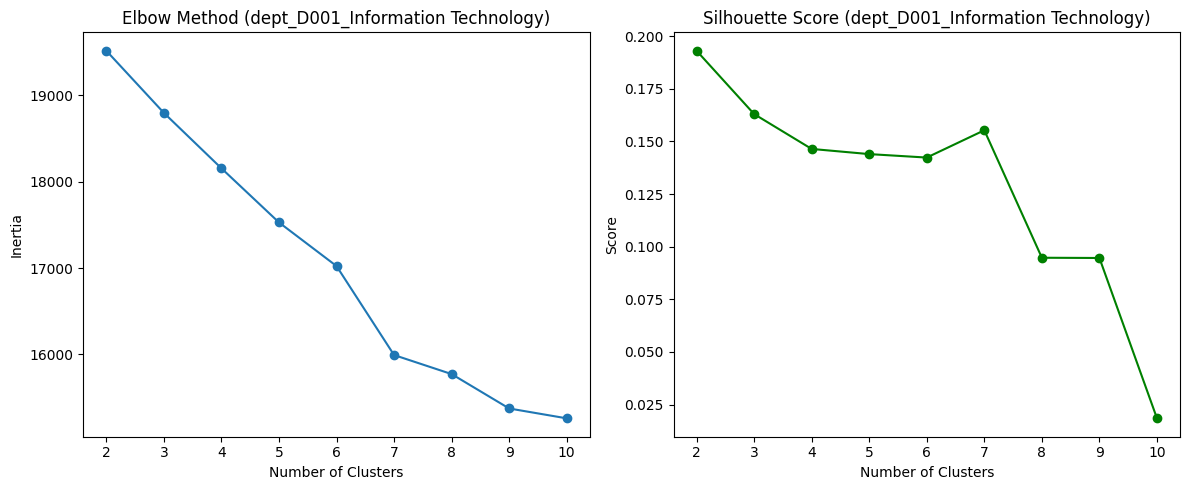


 Analyzing department: dept_D002_Finance


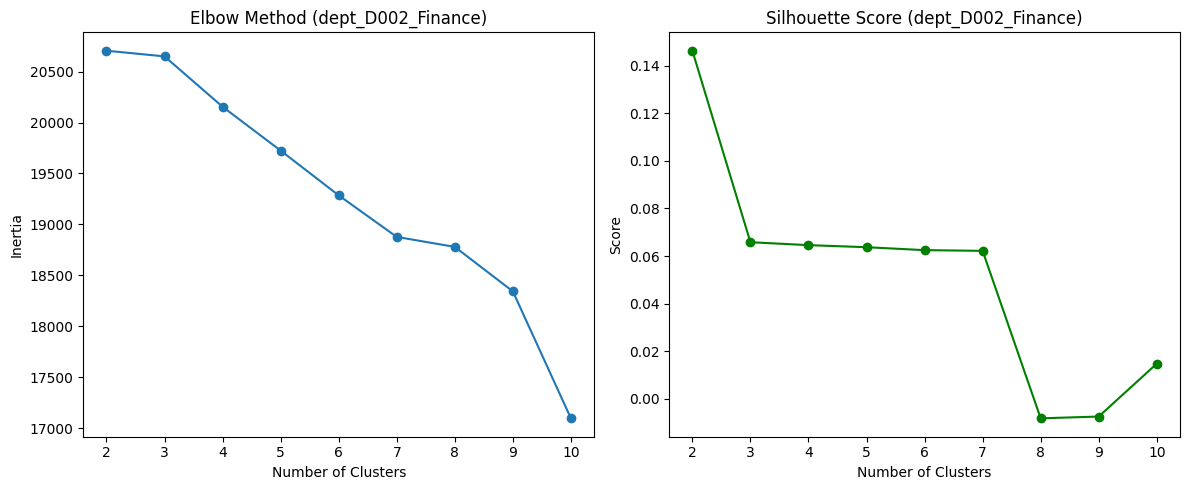


 Analyzing department: dept_D003_Human Resources


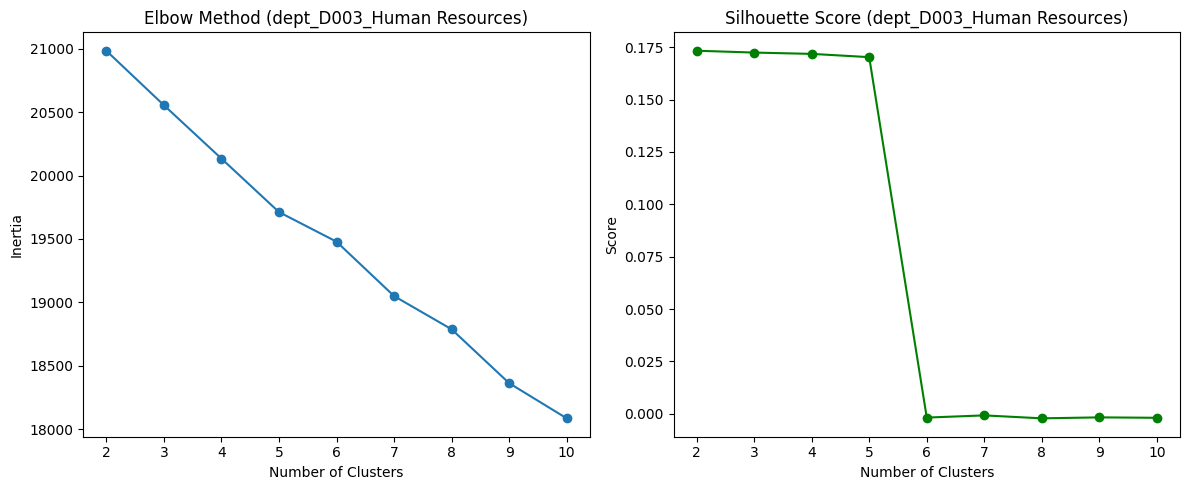


 Analyzing department: dept_D004_Operations


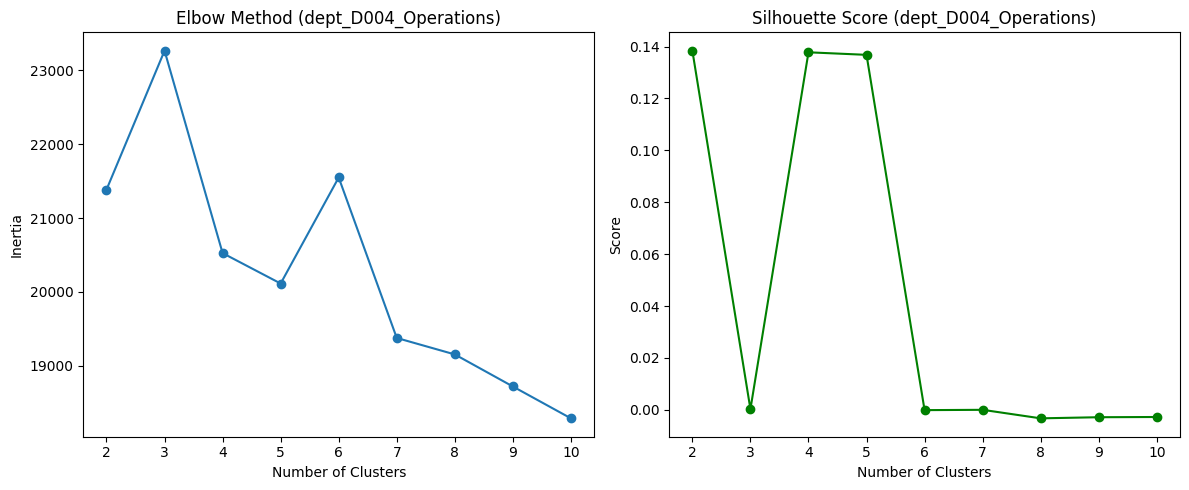


 Analyzing department: dept_D005_Risk Management


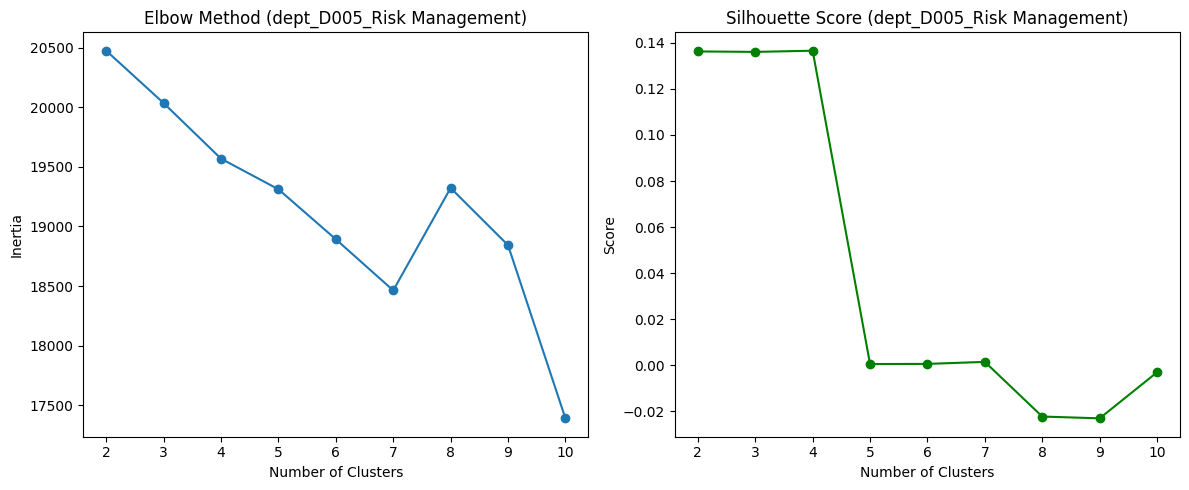


 Analyzing department: dept_D006_Infrastructure


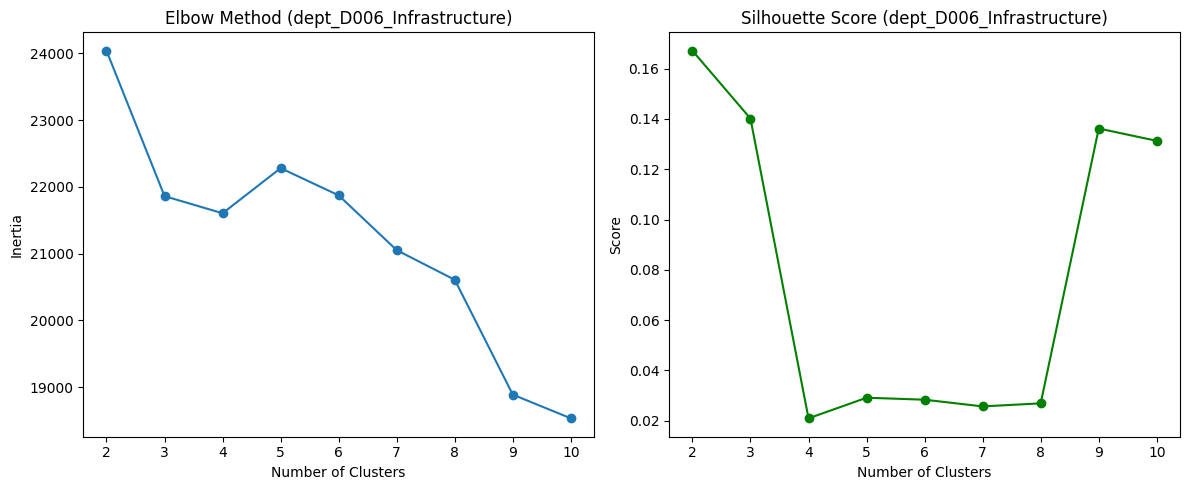


 Analyzing department: dept_D007_Application Development


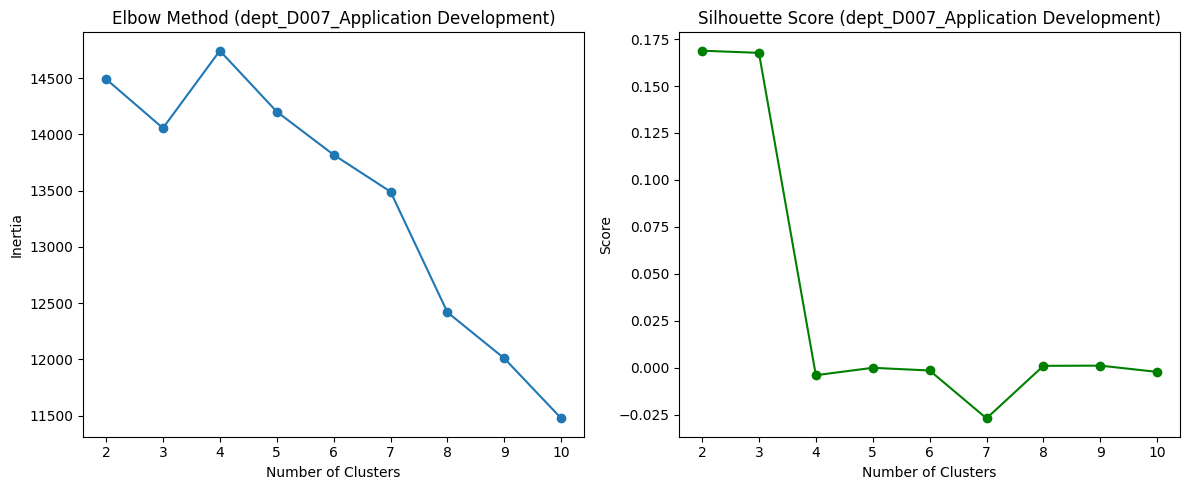


 Analyzing department: dept_D008_Recruitment


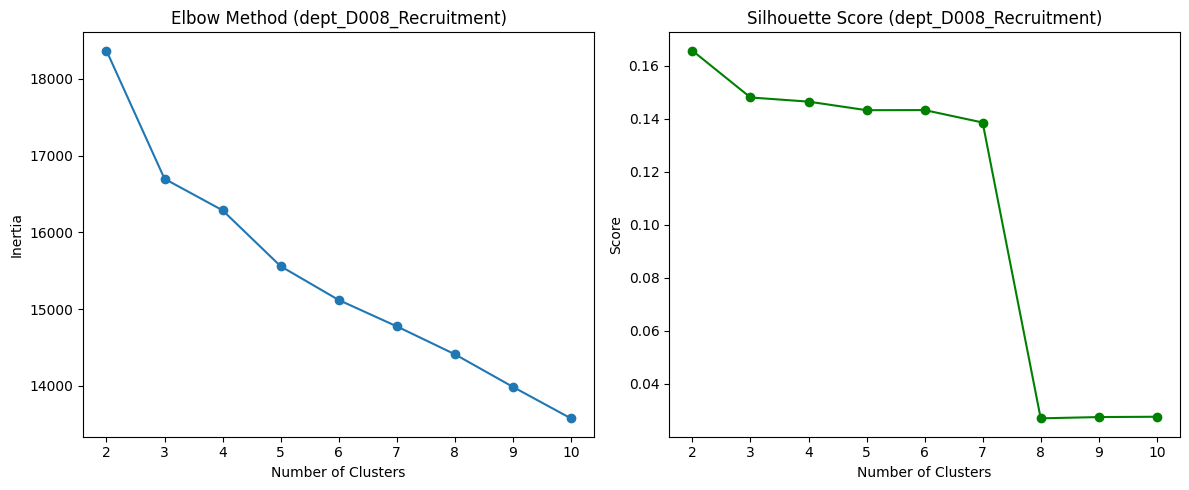


 Analyzing department: dept_D009_Accounting


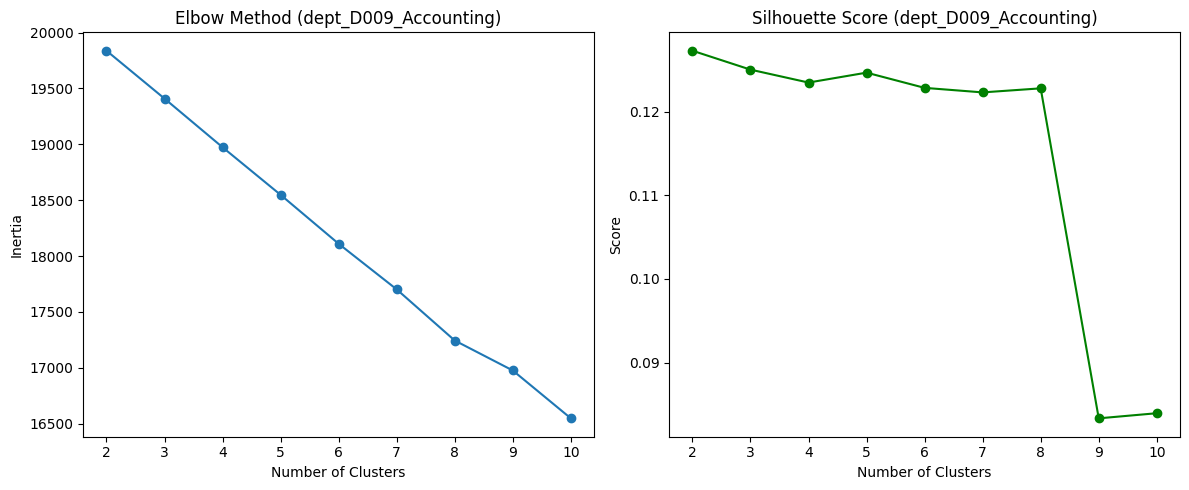


 Analyzing department: dept_D010_Financial Planning


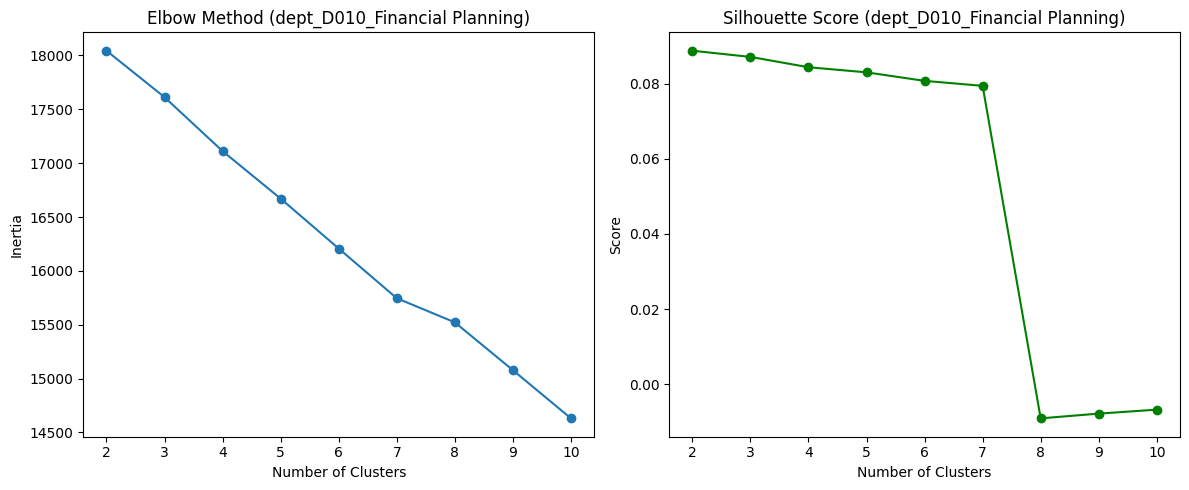


 Analyzing department: dept_D011_Treasury


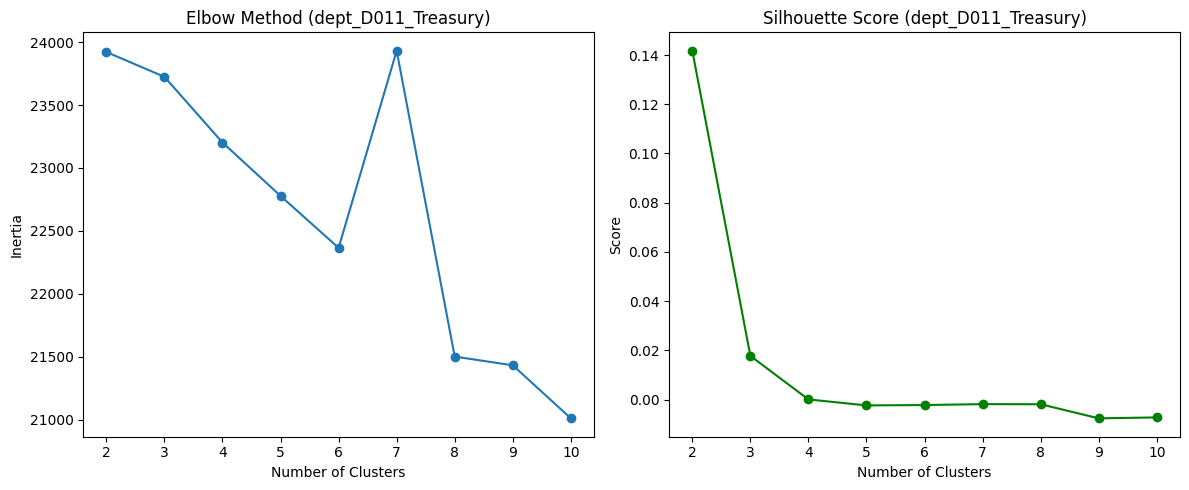


 Analyzing department: dept_D012_Security


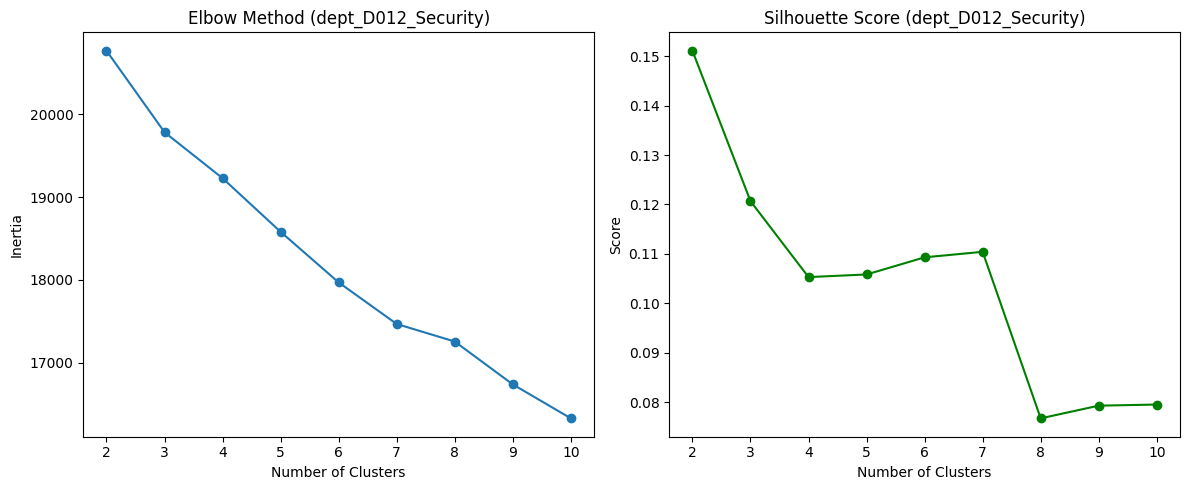


 Analyzing department: dept_D013_Credit Risk


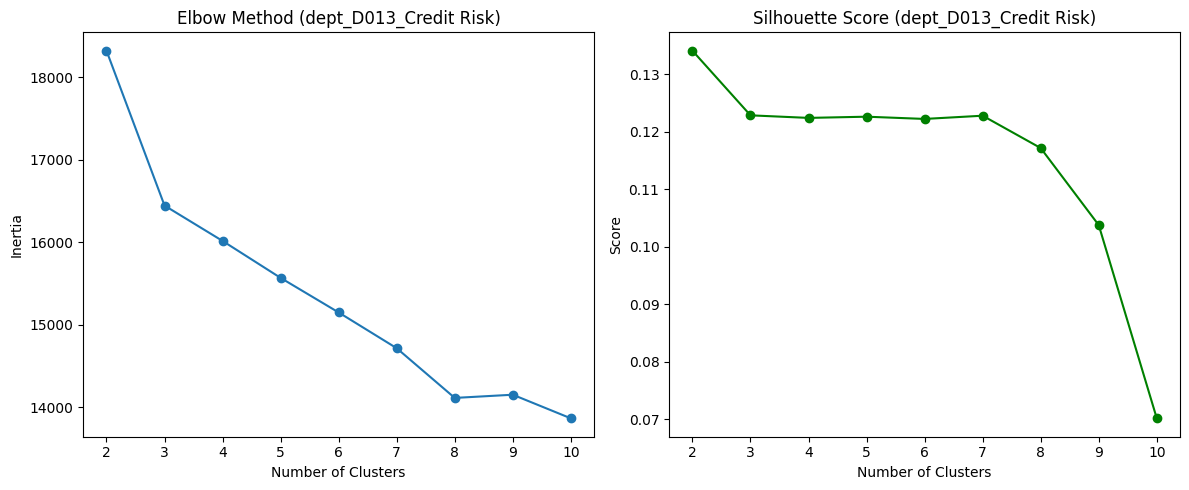


 Analyzing department: dept_D014_Data Management


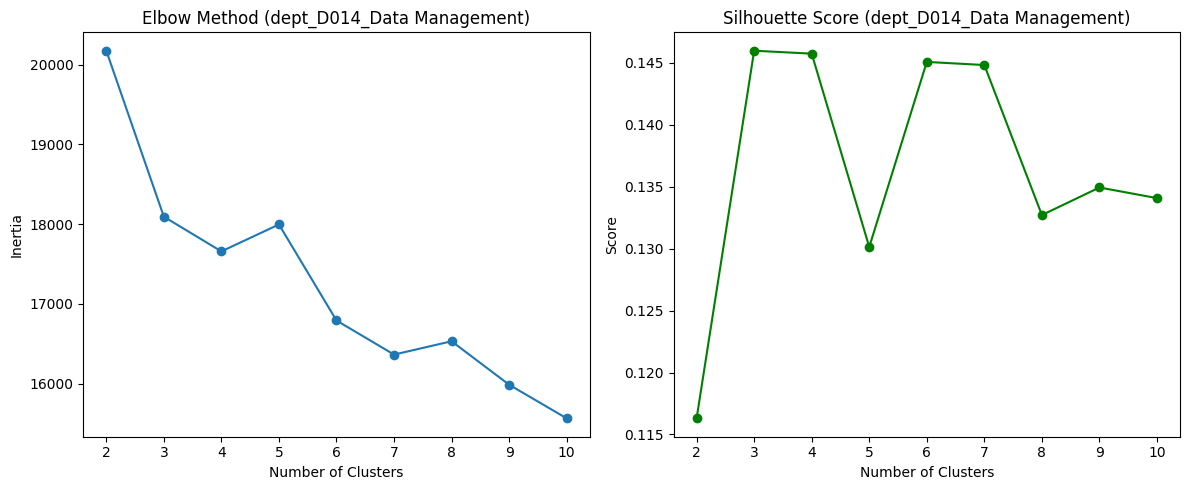


 Analyzing department: dept_D015_Market Risk


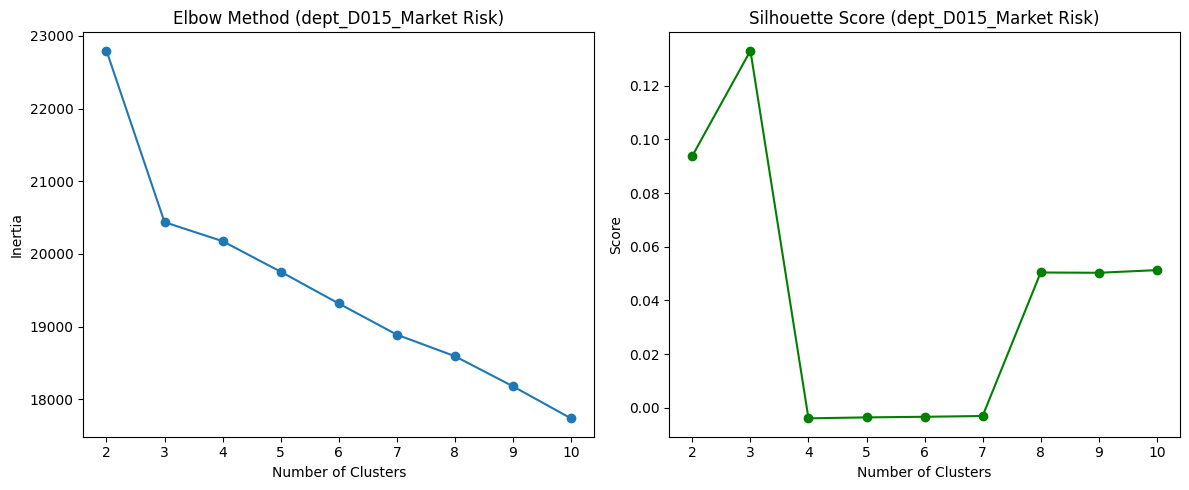

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Loop over each department's binarized entitlement matrix
for dept_key, bdf in binarizers_per_dept_dfs.items():
    print(f"\n Analyzing department: {dept_key}")

    # Step 1: Prepare the feature matrix (exclude employee_id and employee_name)
    X = bdf.drop(columns=['employee_id', 'employee_name'])

    # Step 2: Choose range of k values
    k_values = range(2, 11)
    inertias = []
    silhouette_scores = []

    # Step 3: Perform KMeans and calculate metrics
    for k in k_values:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)

        inertias.append(model.inertia_)

        # Only compute silhouette if number of samples > number of clusters
        if len(X) > k:
            score = silhouette_score(X, labels)
        else:
            score = float('nan')  # Not enough samples to compute
        silhouette_scores.append(score)

    # Step 4: Plot Elbow and Silhouette side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Elbow Plot
    axs[0].plot(k_values, inertias, marker='o')
    axs[0].set_title(f'Elbow Method ({dept_key})')
    axs[0].set_xlabel('Number of Clusters')
    axs[0].set_ylabel('Inertia')

    # Silhouette Plot
    axs[1].plot(k_values, silhouette_scores, marker='o', color='green')
    axs[1].set_title(f'Silhouette Score ({dept_key})')
    axs[1].set_xlabel('Number of Clusters')
    axs[1].set_ylabel('Score')

    plt.tight_layout()
    plt.show()


### Visualize the cluster (Kmeans)

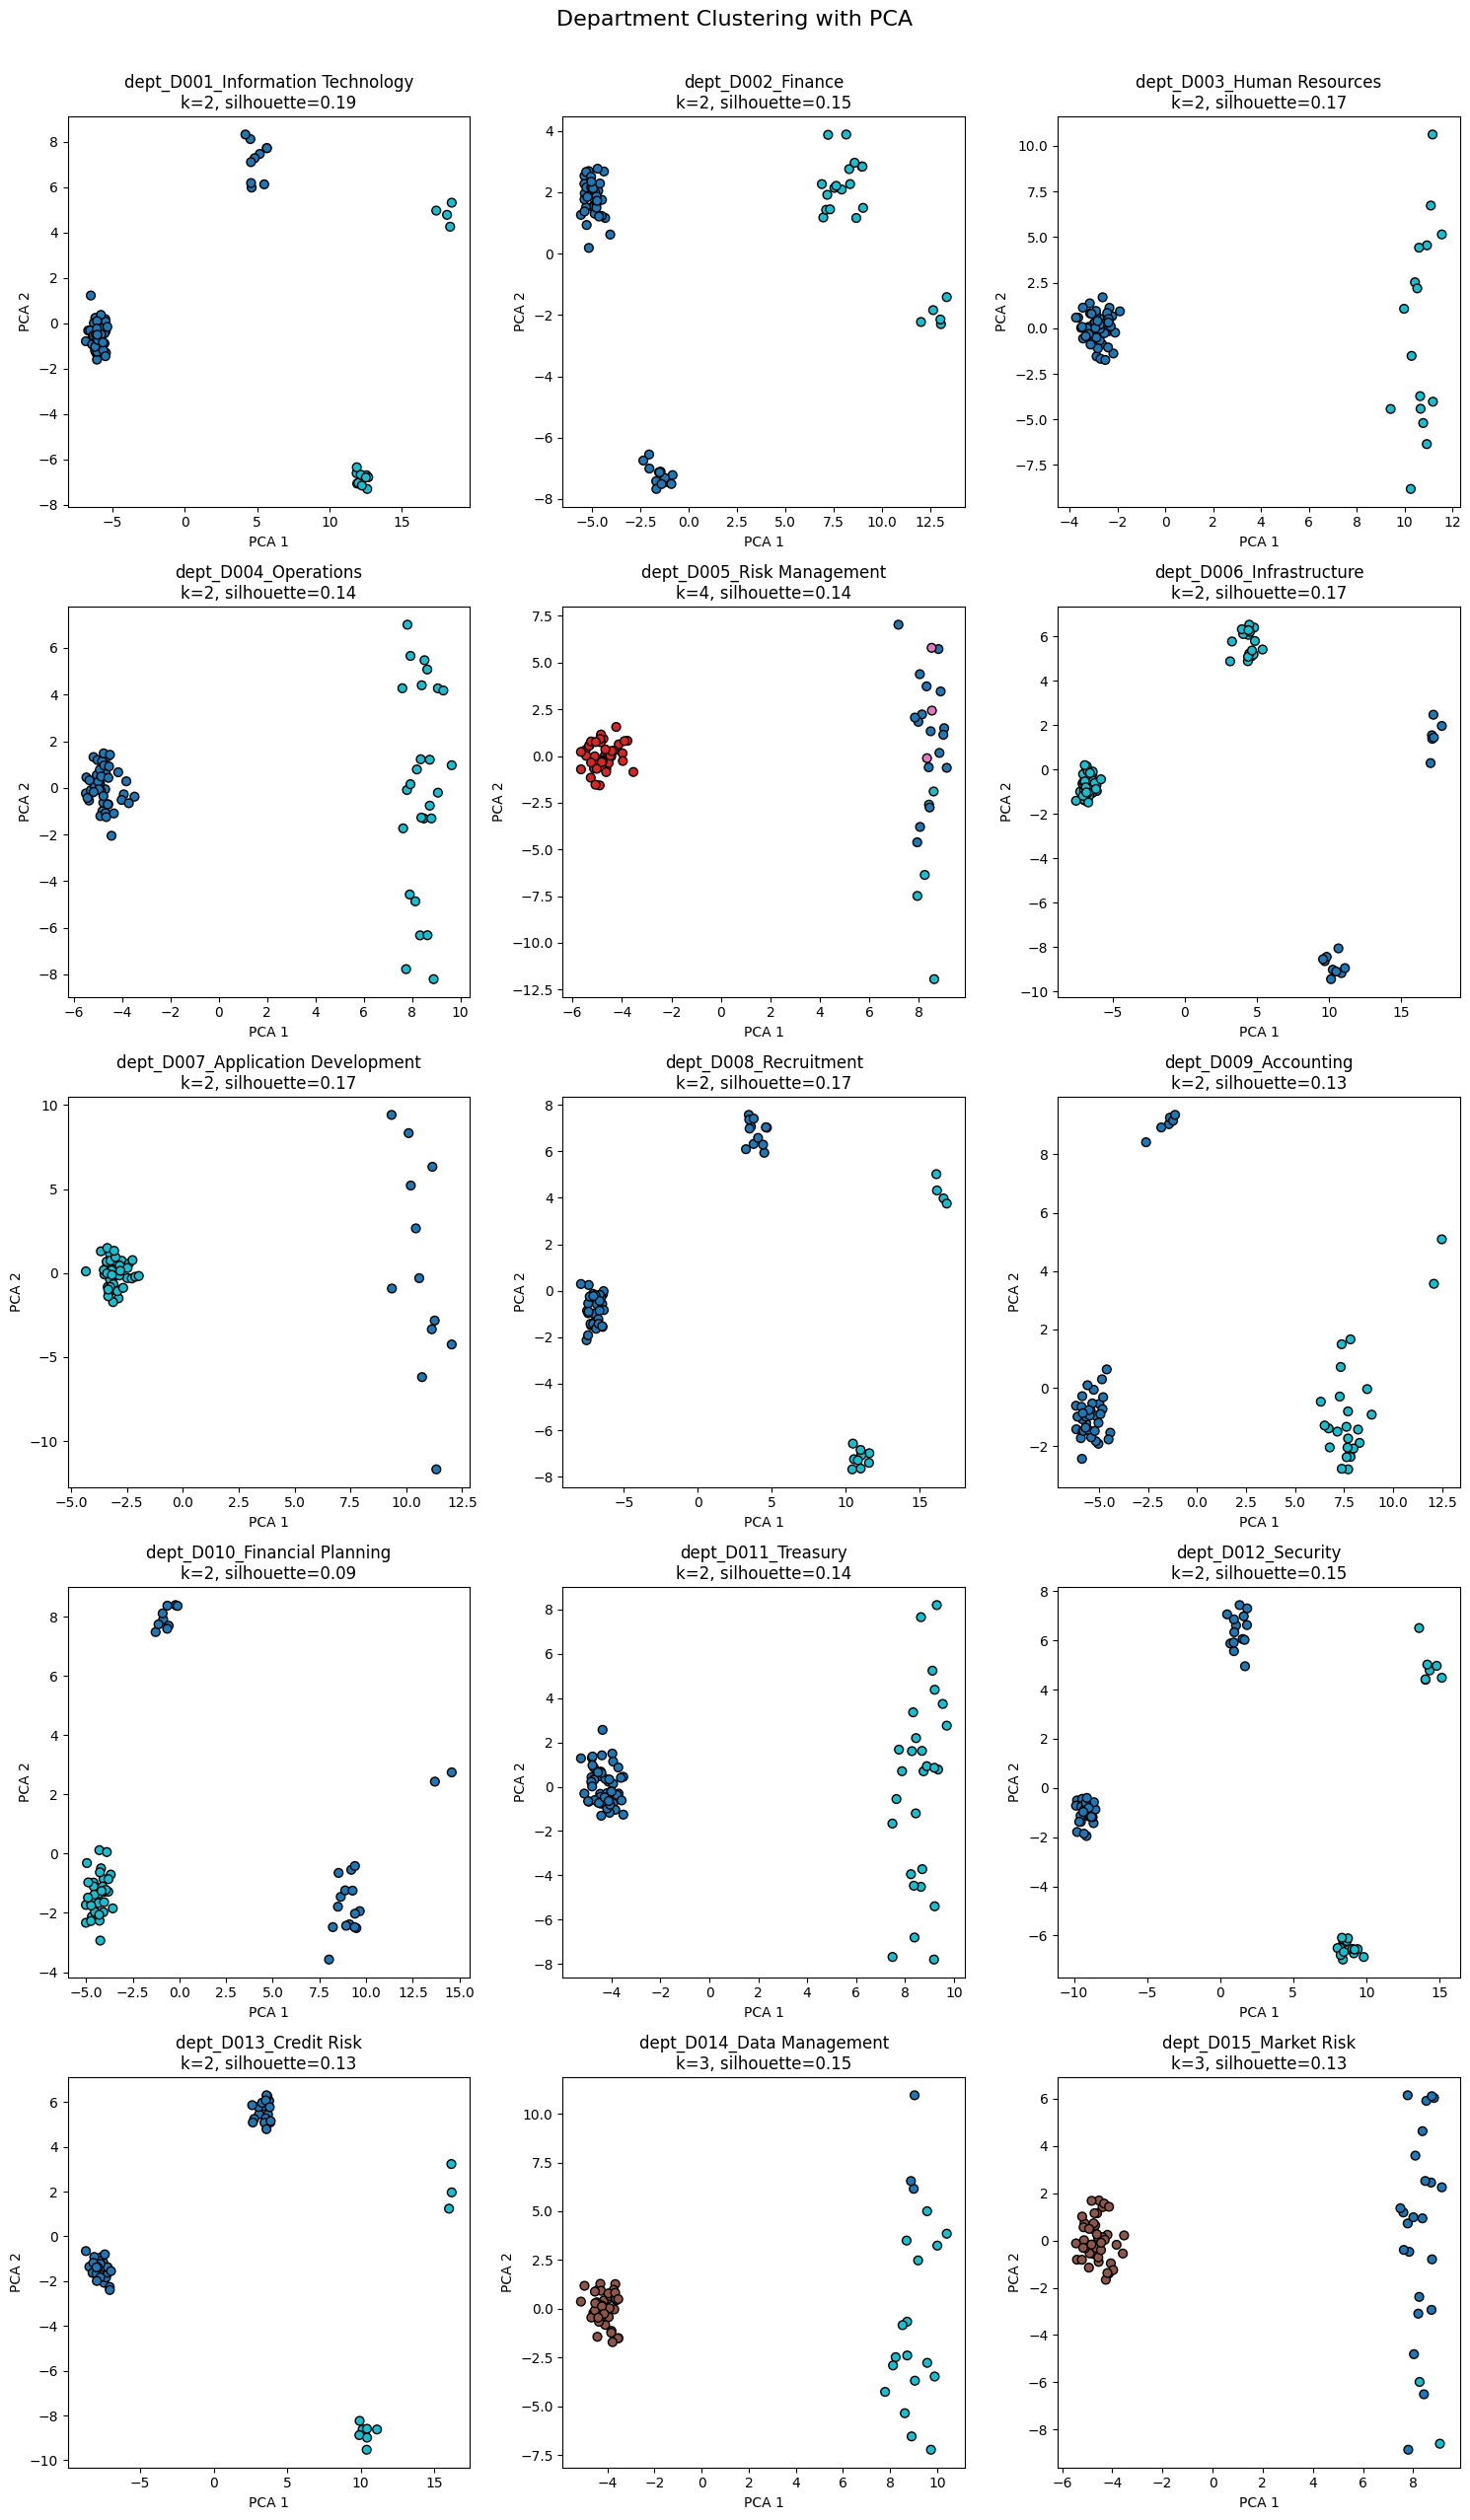

In [27]:

# Store results if needed later
cluster_results = {}
updated_binarized_dfs ={}

# Plot setup: calculate number of rows/cols needed
n_depts = len(binarizers_per_dept_dfs)
n_cols = 3
n_rows = (n_depts + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axs = axs.flatten()  # Flatten in case of single row

for i, (dept_key, bdf) in enumerate(binarizers_per_dept_dfs.items()):
    # Prepare the data matrix
    X = bdf.drop(columns=['employee_id', 'employee_name'])

    # Select best k using silhouette score
    best_k = None
    best_score = -1
    best_labels = None
    for k in range(2, min(11, len(X))):  # Don't try k > #samples
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        if score > best_score:
            best_k = k
            best_score = score
            best_labels = labels

    # Store cluster info
    cluster_results[dept_key] = {
        'k': best_k,
        'silhouette': best_score,
        'labels': best_labels
    }


    # Step 3: Save cluster labels back to DataFrame
    bdf = bdf.copy()
    bdf['cluster'] = best_labels
    updated_binarized_dfs[dept_key] = bdf



    # Perform PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot PCA cluster results
    ax = axs[i]
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=best_labels, cmap='tab10', edgecolor='k', s=40
    )
    ax.set_title(f"{dept_key}\nk={best_k}, silhouette={best_score:.2f}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

# Hide any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Department Clustering with PCA", fontsize=16, y=1.02)
plt.show()


### Use plotly

In [26]:
# import plotly.express as px

# # Store cluster info
# cluster_results = {}

# # Optional: To track updated DataFrames with cluster labels
# updated_binarized_dfs = {}

# for dept_key, bdf in binarizers_per_dept_dfs.items():
#     print(f" Processing: {dept_key}")

#     # Step 1: Prepare features
#     X = bdf.drop(columns=['employee_id', 'employee_name'])

#     # Step 2: Find best k (optimal number of clusters)
#     best_k = None
#     best_score = -1
#     best_labels = None

#     for k in range(2, min(11, len(X))):  # Don't go beyond sample size
#         model = KMeans(n_clusters=k, random_state=42)
#         labels = model.fit_predict(X)

#         if len(set(labels)) > 1:  # Avoid silhouette error for single cluster
#             score = silhouette_score(X, labels)
#             if score > best_score:
#                 best_k = k
#                 best_score = score
#                 best_labels = labels

#     if best_labels is None:
#         print(f"Skipping {dept_key}: Not enough data to cluster.")
#         continue

#     # Step 3: Save cluster labels back to DataFrame
#     bdf = bdf.copy()
#     bdf['cluster'] = best_labels
#     updated_binarized_dfs[dept_key] = bdf

#     # # Step 4: Perform PCA
#     # pca = PCA(n_components=2)
#     # X_pca = pca.fit_transform(X)

#     # # Step 5: Create Plotly scatter plot with hover
#     # fig = px.scatter(
#     #     x=X_pca[:, 0], y=X_pca[:, 1],
#     #     color=bdf['cluster'].astype(str),
#     #     hover_data={
#     #         'employee_name': bdf['employee_name'],
#     #         'employee_id': bdf['employee_id'],
#     #         'PCA1': X_pca[:, 0],
#     #         'PCA2': X_pca[:, 1],
#     #     },
#     #     labels={'color': 'Cluster'},
#     #     title=f"{dept_key} — k={best_k}, silhouette={best_score:.2f}"
#     # )
#     # fig.update_layout(
#     #     xaxis_title="PCA 1",
#     #     yaxis_title="PCA 2",
#     #     legend_title="Cluster"
#     # )

#     # # Step 6: Show the interactive plot
#     # fig.show()

#     # Step 7: Store clustering info if needed later
#     cluster_results[dept_key] = {
#         'k': best_k,
#         'silhouette': best_score,
#         'labels': best_labels
#     }


## Extract Entitlement Bundles (Roles) in each department

In [28]:
entitlement_bundles = {}

for dept_key, df in updated_binarized_dfs.items():
    # Identify entitlement columns (exclude metadata columns)
    entitlement_cols = df.columns.difference(['employee_id', 'employee_name', 'cluster'])

    # Extract bundle per employee
    bundles = []
    for _, row in df.iterrows():
        entitlements = set(entitlement_cols[row[entitlement_cols] == 1])
        bundles.append(entitlements)

    # Add the bundles as a new column
    df = df.copy()
    df['entitlement_bundle'] = bundles

    # Save updated DataFrame back
    updated_binarized_dfs[dept_key] = df

    # Optionally store separately too
    entitlement_bundles[dept_key] = df[['employee_id', 'employee_name', 'entitlement_bundle']]


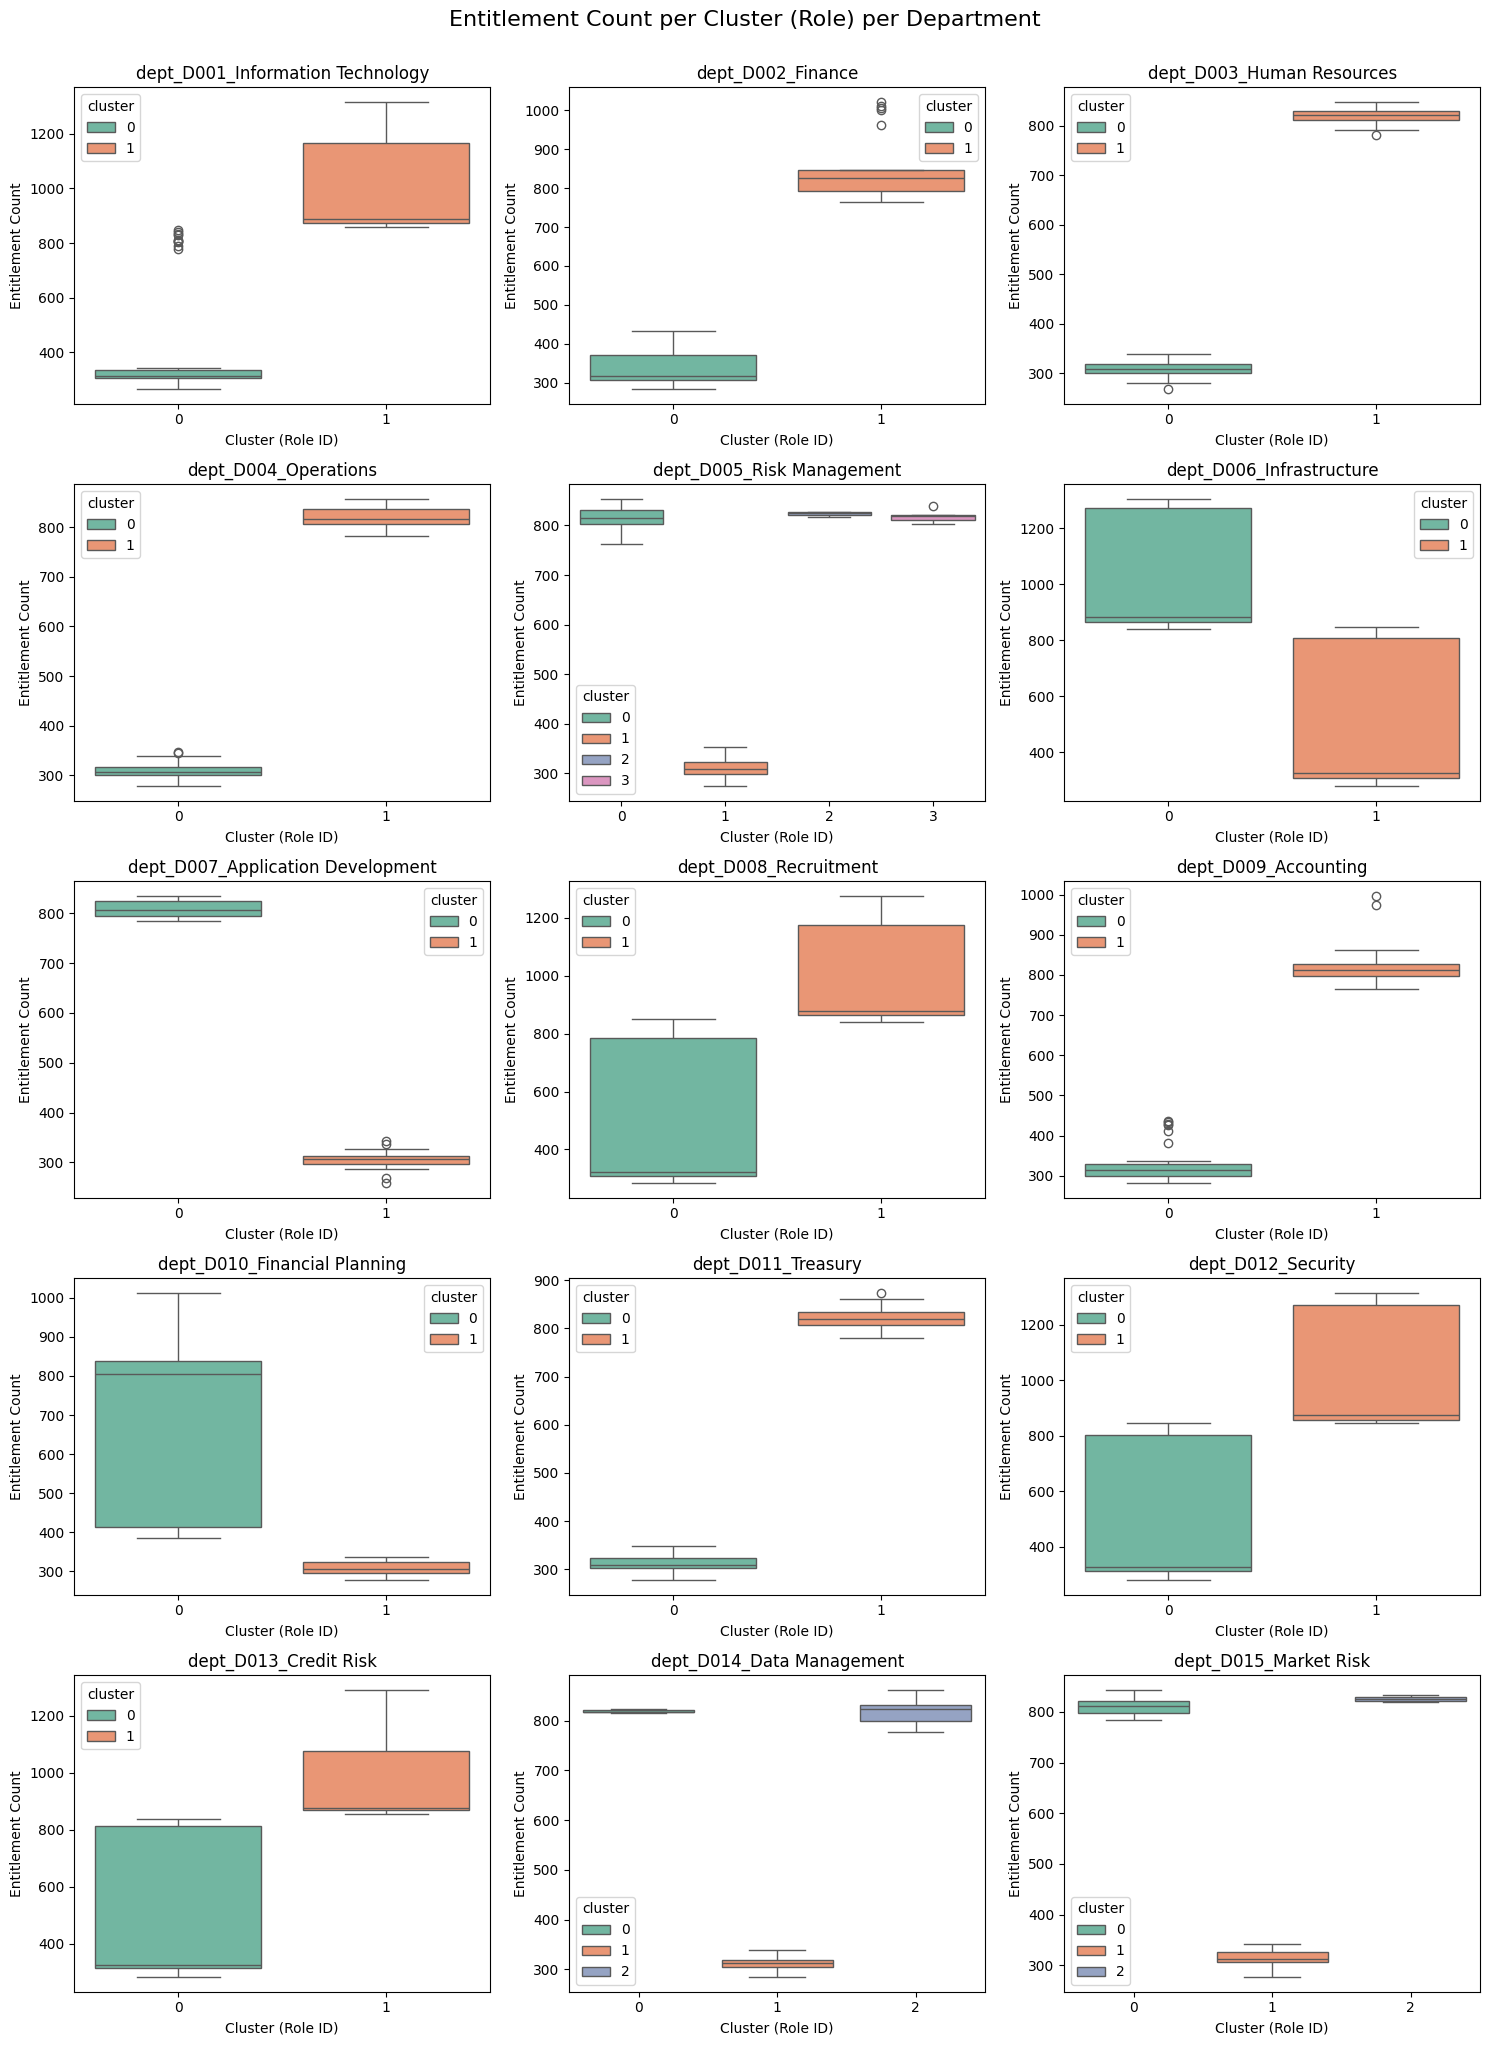

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setup subplot grid
n_depts = len(updated_binarized_dfs)
n_cols = 3
n_rows = (n_depts + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, (dept_key, df) in enumerate(updated_binarized_dfs.items()):
    ax = axs[i]

    # Compute entitlement count per employee
    df = df.copy()
    df['entitlement_count'] = df['entitlement_bundle'].apply(len)

    # Plot boxplot: entitlement count vs. cluster
    sns.boxplot(
        x='cluster',
        y='entitlement_count',
        data=df,
        hue='cluster',
        ax=ax,
        palette='Set2'
    )

    ax.set_title(dept_key)
    ax.set_xlabel("Cluster (Role ID)")
    ax.set_ylabel("Entitlement Count")

# Hide unused axes if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.suptitle("Entitlement Count per Cluster (Role) per Department", fontsize=16, y=1.02)
plt.show()


### Estimate Attestation Reduction

In [36]:
attestation_stats = {}

for dept_key, df in updated_binarized_dfs.items():
    df = df.copy()
    df['entitlement_count'] = df['entitlement_bundle'].apply(len)

    # Total number of entitlement-based reviews
    entitlement_reviews = df['entitlement_count'].sum()

    # Compute the "ideal" bundle per cluster
    cluster_bundles = (
        df.groupby('cluster')['entitlement_bundle']
        .apply(lambda sets: set().union(*sets))
        .to_dict()
    )

    # For each employee, compare their entitlements to the role (cluster) bundle
    df['is_exception'] = df.apply(
        lambda row: row['entitlement_bundle'] != cluster_bundles[row['cluster']],
        axis=1
    )

    # Role-based reviews = one per cluster + one per exception
    num_clusters = df['cluster'].nunique()
    num_exceptions = df['is_exception'].sum()
    role_reviews = num_clusters + num_exceptions

    reduction = (1 - role_reviews / entitlement_reviews) * 100 if entitlement_reviews > 0 else 0

    attestation_stats[dept_key] = {
        'entitlement_reviews': int(entitlement_reviews),
        'role_reviews': int(role_reviews),
        'exceptions': int(num_exceptions),
        'clusters': int(num_clusters),
        'attestation_reduction_percent': round(reduction, 2)
    }


    # Sum totals across departments
total_entitlement_reviews = sum(d['entitlement_reviews'] for d in attestation_stats.values())
total_role_reviews = sum(d['clusters'] + d['exceptions'] for d in attestation_stats.values())

global_reduction = (
    (1 - total_role_reviews / total_entitlement_reviews) * 100
    if total_entitlement_reviews > 0 else 0
)

# Add to results
attestation_stats['GLOBAL'] = {
    'entitlement_reviews': total_entitlement_reviews,
    'role_reviews': total_role_reviews,
    'exceptions': sum(d['exceptions'] for d in attestation_stats.values()),
    'clusters': sum(d['clusters'] for d in attestation_stats.values()),
    'attestation_reduction_percent': round(global_reduction, 2)
}



### Visualise Attestations

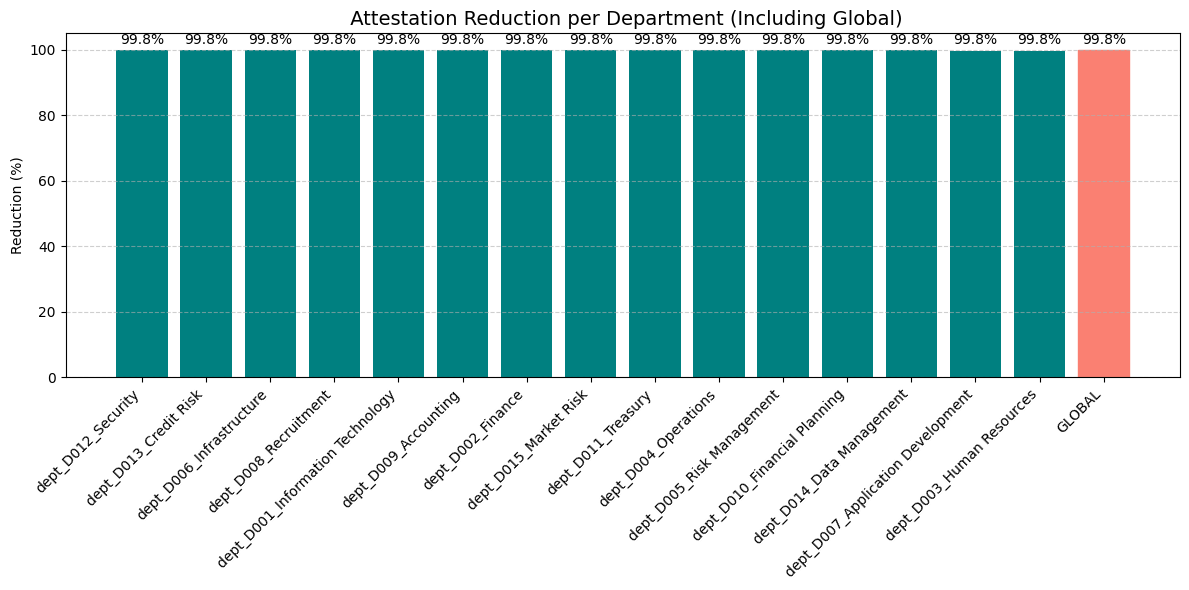

In [38]:
# Create DataFrame from results
attest_df = pd.DataFrame(attestation_stats).T.reset_index().rename(columns={'index': 'department'})

# Reorder: departments sorted + GLOBAL last
global_row = attest_df[attest_df['department'] == 'GLOBAL']
dept_rows = attest_df[attest_df['department'] != 'GLOBAL'].sort_values(by='attestation_reduction_percent', ascending=False)
attest_df = pd.concat([dept_rows, global_row], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(attest_df['department'], attest_df['attestation_reduction_percent'], color='teal')
bars[-1].set_color('salmon')  # Highlight GLOBAL

# Annotate values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.title(' Attestation Reduction per Department (Including Global)', fontsize=14)
plt.ylabel('Reduction (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()